In [1]:
%matplotlib inline
if 0:
    import matplotlib
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathlib import Path
from utils import getsize
import pandas as pd
from collections import OrderedDict

In [2]:
files = Path('res/second/')

In [3]:
data = {}
for fl in files.glob('*?test4.pkl'):
    with open(fl, 'rb') as fh: data[str(fl)] = pickle.load(fh)

In [4]:
KEYS = list(data.keys())
KEYS = sorted(KEYS)

N = len(data[KEYS[0]][1])
L = data[KEYS[0]][1][0]['L']

df = pd.DataFrame([k.replace('--', '-')[11:-10].split('-') for k in KEYS])
df.columns = ['N', 'T', 'D', 'pt', 'market', 'freq', 'seed', 'only_update_price', 'flat', 'start']

df.flat = df.flat.fillna(False)
df.only_update_price = df.only_update_price.fillna(False)

for col in ['N', 'T', 'D', 'seed', 'start']:
    df[col] = df[col].astype(int)
    
for col in ['only_update_price', 'flat', 'market']:
    df[col] = df[col].map(lambda x: True if x=='True' else False)

In [5]:
def get_default_key(num, df):
    tmp = df.loc[num]
    default = df[
        (df.seed == tmp.seed) &
        (df.start == tmp.start) &
        (df.flat == tmp.flat) &
        (df.market == False)
    ].index[0]
    
    return default
    
#get_default_key(41, df)

In [6]:
def social_welfare(num):
    """
    Calculates the social welfare for a the key `num`
    """
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]
    
    
    total_cost = np.array([dt[n]['history_cost'].sum() for n in range(N)]).sum().round()
    default_cost = np.array([dt_default[n]['history_cost'].sum() for n in range(N)]).sum().round()
    
    #print(key, total_cost, default_cost)
    
    res = ((total_cost - default_cost) / default_cost) * 100
    
    return res

def increase_in_range(num, df):
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]
    
    

    net_load = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    default_load = np.vstack([dt_default[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    nl_max, nl_min = net_load.max(), net_load.min()
    dl_max, dl_min = default_load.max(), default_load.min()
    
    top_range = round(((nl_max - dl_max) / np.abs(dl_max)) * 100, 2)
    bottom_range = round(((dl_min - nl_min) / np.abs(nl_min)) * 100, 2)
    
    bottom_range = bottom_range if np.abs(bottom_range) < 1e4 else None
    top_range = top_range if np.abs(top_range) < 1e4 else None
    
    
    return bottom_range, top_range 

def matched_local(num, df):
    
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]

    l = np.vstack([dt[n]['history_post_net'] for n in range(N)])[:, : L - 47]
    d = np.vstack([dt_default[n]['history_post_net'] for n in range(N)])[: L - 47]
    
    l_p = np.clip(l, a_max=1e7, a_min=0)
    l_n = np.clip(-l, a_max=1e7, a_min=0)

    d_p = np.clip(d, a_max=1e7, a_min=0)
    d_n = np.clip(-d, a_max=1e7, a_min=0)
    
    net_matched = np.minimum(l_n.sum(axis=0), l_p.sum(axis=0)).sum()
    default_matched = np.minimum(d_n.sum(axis=0), d_p.sum(axis=0)).sum()
    
    inc = np.round(((net_matched - default_matched) / np.abs(default_matched)) * 100 , 2)
    
    return inc
    

#matched_local(1, df)

In [7]:
df['social_cost'] = df.apply(lambda x: social_welfare(x.name), axis=1)
df['increase_bottom_range'] = df.apply(lambda x: increase_in_range(x.name, df)[0], axis=1)
df['increase_top_range'] = df.apply(lambda x: increase_in_range(x.name, df)[1], axis=1)
df['local_matched'] = df.apply(lambda x: matched_local(x.name, df), axis=1)

In [8]:
dist2name = {
    'neutral': 'NEU',
    'optimistic': 'OPT',
    'pesimistic': 'PES',
    'solar': 'SOL',
    'unique': 'UNQ'
}

df_ = df.copy()
METRICS = ['social_cost', 'increase_bottom_range', 'increase_top_range', 'local_matched']
df_['Tariff'] = df_['flat'].map({False: 'TOU', True: 'Flat'})
df_['Belief'] = df_['pt'].map(dist2name)
df_['Update Q'] = ~ df_['only_update_price']
df_['Freq'] =df_['freq']
df_ = df_.drop(['N', 'T', 'D', 'seed', 'start', 'pt', 'flat', 'only_update_price', 'freq'], axis=1)

summary = df_.groupby(['Tariff', 'Update Q', 'Freq', 'Belief'])[METRICS].mean()
summary[METRICS] = summary[METRICS].astype(int)
summary.columns = ['SC', 'min', 'max', 'LM']
#summar.astype(int)

In [9]:
with open('img/table.tex', 'w') as fh:
    fh.write(summary.to_latex(escape=False))
    
summary

SC  min  max  LM
Tariff Update Q Freq Belief                  
Flat   False    1    NEU     -3  -33    1 -15
                     OPT     -3  -38    1 -19
                     PES     -2  -51    0  -6
                     SOL     -4  -90    1  36
                     UNQ     -3  -24    2  16
                5    NEU     -3   12    2 -21
                     OPT     -4  -42    2  -3
                     PES     -1   -4    0   0
                     SOL     -3  -48    0  53
                     UNQ      1   49    2  63
       True     1    NEU     -3  -62    1   0
                     OPT     -4  -96    1   3
                     PES     -2  -38    0   0
                     SOL     -3  -84   -1  21
                     UNQ     -3  -89   -1  37
                5    NEU     -3   -4    2  -7
                     OPT     -4  -55    2   8
                     PES     -1   -3    0   0
                     SOL     -2  -17    0  11
                     UNQ     -1    0   -1   0
                None PES      0    0    0   0
                     SOL    -12   -5  264  32
TOU    False    1    NEU     -1  -40  112 -19
                     OPT      7  -54  -52  65
                     PES      0  -51   20 -15
                     SOL      8 -124  -53  32
                     UNQ     10  -13  -53  26
                5    NEU     -1   17  117 -15
                     OPT      5 -110  -53  98
                     PES      0   -1   20   0
                     SOL      9  -19  -53  43
                     UNQ     15   49  -54  44
       True     1    NEU     -1  -50   95  -6
                     OPT      6 -145  -53  74
                     PES      0  -27   20  -4
                     SOL      0  -34    6  40
                     UNQ      0  -66  -19  41
                5    NEU     -1    6  101  -7
                     OPT      6 -101  -53  85
                     PES      0   -1   20   0
                     SOL      0  -19    2   9
                     UNQ      0    9  -26   3
                None PES      0    0    0   0
                     SOL     -7   -1  -20  43

In [10]:
def basic_plot(seed, update_q, tariff, start):
    df_ = df[
        (df.seed == seed) & ((df.only_update_price == update_q) | (df.freq == 'None')) & (df.flat == tariff) & (df.start == start)
    ].copy()
    
    def_key = df_[(df_.pt == 'pesimistic') & (df_.market == False)].index[0]
    dt = data[KEYS[def_key]][1]
    defload = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    prices_b = dt[0]['allprices'][:, 3]
    prices_s = dt[0]['allprices'][:, 0]
    
    fig = plt.figure(figsize=(14, 10), constrained_layout=True)
    ax = fig.add_subplot(111)
    
    for l in range(L - 47):
        color = 'y' if prices_b[l] > prices_b.min() else 'g'
        ax.axvspan(l, l+1, facecolor=color, alpha=0.3)
    
    

    for i, rows in df_.iterrows():
        dt = data[KEYS[i]][1]
        if rows.pt == 'solar' and rows.market is False:
            color = 'k'
            width = 1
            label = 'Solar Belief'
        elif rows.pt == 'pesimistic' and rows.market is False:
            continue
            #color = 'k'
            #width = 1
            #label = 'Solar Tariff'
        else:
            color = 'r'
            width = 0.5
            label = 'Other beliefs'
        netload = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
        ax.plot(netload - defload, color=color, linewidth=width, label=label)
    ax.legend()
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    
    name = 'img/{}_{}_{}_{}'.format(seed, update_q, tariff, start)
    

    
    ax.set_xlabel('Time-slots')
    ax.set_ylabel('Net energy consumption (kWh)')
    
    ax.set_xlim(0, L - 47)
    
    #ax.legend(l
    
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(.5, 1.3),
          ncol=2, fancybox=True, shadow=True)
    
    phi = (1 + np.sqrt(5)) * 0.5
    fig.set_size_inches(3.5, 3.5 / phi)
    fig.tight_layout(pad=0)
    fig.savefig(name + '.pgf')
    fig.show()
    
    return df_

/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


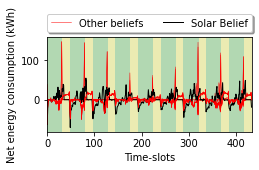

In [11]:
df_ = basic_plot(seed=101, update_q=True, tariff=False, start=130)

/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


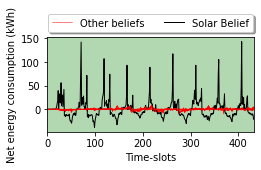

In [12]:
df_ = basic_plot(seed=101, update_q=False, tariff=True, start=130)

In [13]:
def pre_post_plot(seed, update_q, tariff, start, pt, freq):
    df_ = df[
        (df.seed == seed) & ((df.only_update_price == update_q) | (df.freq == 'None')) &
        (df.flat == tariff) & (df.start == start) & (df.pt == pt) & (df.freq == str(freq))
    ].copy()
    
    key = df_.index[0]
    dt = data[KEYS[key]][1]
    
    #def_key = df_[(df_.pt == 'pesimistic') & (df_.market == False)].index[0]
    #
    #defload = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    prices_b = dt[0]['allprices'][:, 3]
    prices_s = dt[0]['allprices'][:, 0]
    
    pre_load = np.vstack([dt[n]['history_pre_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    post_load = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    
    #return df_
    
    fig = plt.figure(figsize=(14, 10), constrained_layout=True)
    ax = fig.add_subplot(111)
    
    for l in range(L - 47):
        color = 'y' if prices_b[l] > prices_b.min() else 'g'
        ax.axvspan(l, l+1, facecolor=color, alpha=0.3)
    

    ax.plot(pre_load, label='Desired Load', c='r')
    ax.plot(post_load, label='Consumed Load', c='b')
    
    ax.legend()
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    
    name = 'img/{}_{}_{}_{}_{}_{}_pre_post'.format(seed, update_q, tariff, start, pt, freq)
    

    
    ax.set_xlabel('Time-slots')
    ax.set_ylabel('Net energy consumption (kWh)')
    
    ax.set_xlim(0, L - 47)

    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(.5, 1.3),
          ncol=2, fancybox=True, shadow=True)
    
    phi = (1 + np.sqrt(5)) * 0.5
    fig.set_size_inches(3.5, 3.5 / phi)
    fig.tight_layout(pad=0)
    fig.savefig(name + '.pgf')
    fig.show()
    
    return df_

/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,N,T,D,pt,market,freq,seed,only_update_price,flat,start,social_cost,increase_bottom_range,increase_top_range,local_matched
0,50,48,10,neutral,True,1,101,False,False,130,-1.447082,-47.13,92.55,2.74


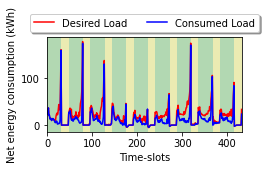

In [14]:
pre_post_plot(seed=101, update_q=False, tariff=False, start=130, pt='neutral', freq=1)

/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,N,T,D,pt,market,freq,seed,only_update_price,flat,start,social_cost,increase_bottom_range,increase_top_range,local_matched
40,50,48,10,optimistic,True,1,101,False,False,130,7.788407,-149.74,-55.34,99.97


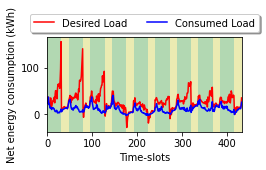

In [15]:
pre_post_plot(seed=101, update_q=False, tariff=False, start=130, pt='optimistic', freq=1)

In [17]:
20 / 0.95 / 0.95

22.1606648199446

In [42]:
10 * 1.3

13.0

In [43]:
20 * 0.7

14.0